In [761]:
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import enum
from typing import Callable

In [724]:
input_df = pd.read_csv("data/output.csv")
print(input_df)

       Match #  Team # Position   Scouter           Question   Bubble  Value
0            1    6910   Blue 1  Patricio       AutoMobility  Success  False
1            1    6910   Blue 1  Patricio       AutoMobility      DNA  False
2            1    6910   Blue 1  Patricio         AutoDocked  Success   True
3            1    6910   Blue 1  Patricio         AutoDocked      DNA  False
4            1    6910   Blue 1  Patricio        AutoEngaged  Success  False
...        ...     ...      ...       ...                ...      ...    ...
25891       42    1414    Red 3       Jay    EndgameTeamwork  Success   True
25892       42    1414    Red 3       Jay   EndgamePenalties  Success  False
25893       42    1414    Red 3       Jay    MiscTippedCones  Success   True
25894       42    1414    Red 3       Jay  MiscAdaptStrategy  Success   True
25895       42    1414    Red 3       Jay     MiscDropPieces  Success  False

[25896 rows x 7 columns]


In [725]:
class QuestionCategories(str, enum.Enum):
    Auto = "Auto"
    Teleop = "Teleop"
    Endgame = "Endgame"
    Misc = "Misc"

class NodeNames(str, enum.Enum):
    HighNode = "HighNode"
    MidNode = "MidNode"
    LowNode = "LowNode"

    @classmethod
    def get_values(cls):
        return [e.value for e in cls]

    @property
    def grid_horizontal_size(self):
        return 9

class Points:
    nodes = {
        "AutoHighNode": 6,
        "AutoMidNode": 4,
        "AutoLowNode": 3,

        "TeleopHighNode": 5,
        "TeleopMidNode": 3,
        "TeleopLowNode": 2
    }

    def __getattr__(self, item):
        return self.nodes.get(item)

    def __iter__(self):
        yield from self.nodes

class NodeCols(str, enum.Enum):
    Cone = "Cone"
    Cube = "Cube"
    Hybrid = "Hybrid"

In [726]:
class OutputHeaders(str, enum.Enum):
    Match = "Match #"
    Team = "Team #"
    Position = "Position"
    Scouter = "Scouter"
    Question = "Question"
    Bubble = "Bubble"
    Value = "Value"

    @classmethod
    def get_values(cls):
        return [e.value for e in cls]

In [727]:
def get_grid_rows(df: pd.DataFrame, mode: QuestionCategories = QuestionCategories.Auto, matches=None) -> pd.DataFrame:
    if mode != QuestionCategories.Auto and mode != QuestionCategories.Teleop:
        raise ValueError("question_category must be Auto or Teleop grid")

    if matches is None:
        return df.loc[(df[OutputHeaders.Question].str.contains(mode)) & (df[OutputHeaders.Question].str.contains("|".join(NodeNames)))]
    else:
        return df.loc[(df[OutputHeaders.Match].isin(matches)) & (df[OutputHeaders.Question].str.contains(mode)) & (df[OutputHeaders.Question].str.contains("|".join(NodeNames)))]


def calculate_grid_statistics(df: pd.DataFrame, point_weighted: bool = False, metric: Callable[[pd.DataFrame], float] = lambda df: df[OutputHeaders.Value].mean()):
    common_grid_positions = None
    raw_statistics = []

    for grid_row in NodeNames:
        rows_by_row: pd.DataFrame = df.loc[df[OutputHeaders.Question].str.contains(grid_row)]
        grid_positions = sorted(rows_by_row[OutputHeaders.Bubble].unique(), key=lambda p: p[-1])

        if common_grid_positions is None:
            # this is pretty bad but it is what it is
            common_grid_positions = grid_positions

        # make an exception for low nodes, as they are "hybrid" so there are both cone and cube fields
        if grid_row == NodeNames.LowNode:
            combined_positions = []
            for pos in grid_positions:
                # just assume that the last character in the name is the number, i.e. Cube_5, Cone_2
                existing_pos = next((p for p in combined_positions if pos[-1:] in p), None)
                if existing_pos is None:
                    combined_positions.append(f"{NodeCols.Hybrid}_{pos[-1:]}")

            grid_positions = combined_positions

        col_statistics = []
        for node_col in grid_positions:
            if NodeCols.Hybrid in node_col:
                # again, assume that last character is the number
                ungrouped_cols_by_row: pd.DataFrame = rows_by_row.loc[rows_by_row[OutputHeaders.Bubble].str.contains(node_col[-1:])]
                cols_by_row: pd.DataFrame = ungrouped_cols_by_row.groupby([OutputHeaders.Match])[OutputHeaders.Value].any().to_frame()

                question_containing_cols_by_row = ungrouped_cols_by_row
            else:
                cols_by_row: pd.DataFrame = rows_by_row.loc[rows_by_row[OutputHeaders.Bubble] == node_col]
                question_containing_cols_by_row = cols_by_row

            if point_weighted:
                modes = [m for m in QuestionCategories if m in question_containing_cols_by_row[OutputHeaders.Question].iloc[0]]
                if len(modes) > 1:
                    raise RuntimeError("mode should be unique in passed data")

                mode = modes[0]

                point_weights = {name.replace(mode, ""):value for name, value in Points.nodes.items() if mode in name}

                copied_cols_by_row = question_containing_cols_by_row.copy()
                for name, weight in point_weights.items():
                    copied_cols_by_row[OutputHeaders.Value] = np.where(
                        (copied_cols_by_row[OutputHeaders.Question].str.contains(name) & copied_cols_by_row[OutputHeaders.Value.value]),
                        weight,
                        copied_cols_by_row[OutputHeaders.Value]
                    )

                cols_by_row = copied_cols_by_row

            # mean_prop = extracted_cols_by_row[OutputHeaders.Value].mean()
            # col_means.append(mean_prop)

            statistic = metric(cols_by_row)
            col_statistics.append(statistic)

            # print(extracted_cols_by_row)
            # print(f"{grid_row}:{grid_col}:{mean_prop}")

        raw_statistics.append(col_statistics)

    if common_grid_positions is not None:
        return pd.DataFrame(raw_statistics, index=NodeNames.get_values(), columns=common_grid_positions)
    else:
        raise RuntimeError("should not reach here")



In [754]:
def get_teams_present(df: pd.DataFrame) -> np.ndarray:
    return df[OutputHeaders.Team].unique()

def organize_by_teams(df: pd.DataFrame) -> dict[int, pd.DataFrame]:
    teams_present = get_teams_present(df)
    team_data = {}

    for team in teams_present:
        unsorted_team_rows: pd.DataFrame = df.loc[df[OutputHeaders.Team] == team]
        team_rows: pd.DataFrame = unsorted_team_rows.sort_values(OutputHeaders.Match)

        team_data[team] = team_rows

    return team_data

def get_played_matches(df: pd.DataFrame, team: int) -> np.ndarray:
    return df.loc[df[OutputHeaders.Team] == team, OutputHeaders.Match].unique()

In [755]:
def get_df_max(df: pd.DataFrame) -> float:
    return np.amax(df.to_numpy())

def grid_heatmap(df: pd.DataFrame, team: int, mode: QuestionCategories = None, matches: list[int] = None, pointed_weighted: bool = None):
    grid_rows = get_grid_rows(organize_by_teams(df).get(team), mode=mode, matches=matches)
    statistics_grid = calculate_grid_statistics(grid_rows, point_weighted=pointed_weighted)

    sns.heatmap(statistics_grid, annot=True, square=True, vmin=0, vmax=np.ceil(get_df_max(statistics_grid)), cmap="viridis")

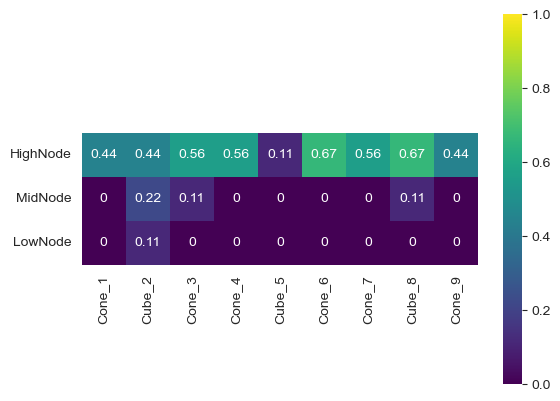

In [756]:
grid_heatmap(df=input_df, team=1683, mode=QuestionCategories.Teleop, pointed_weighted=False)

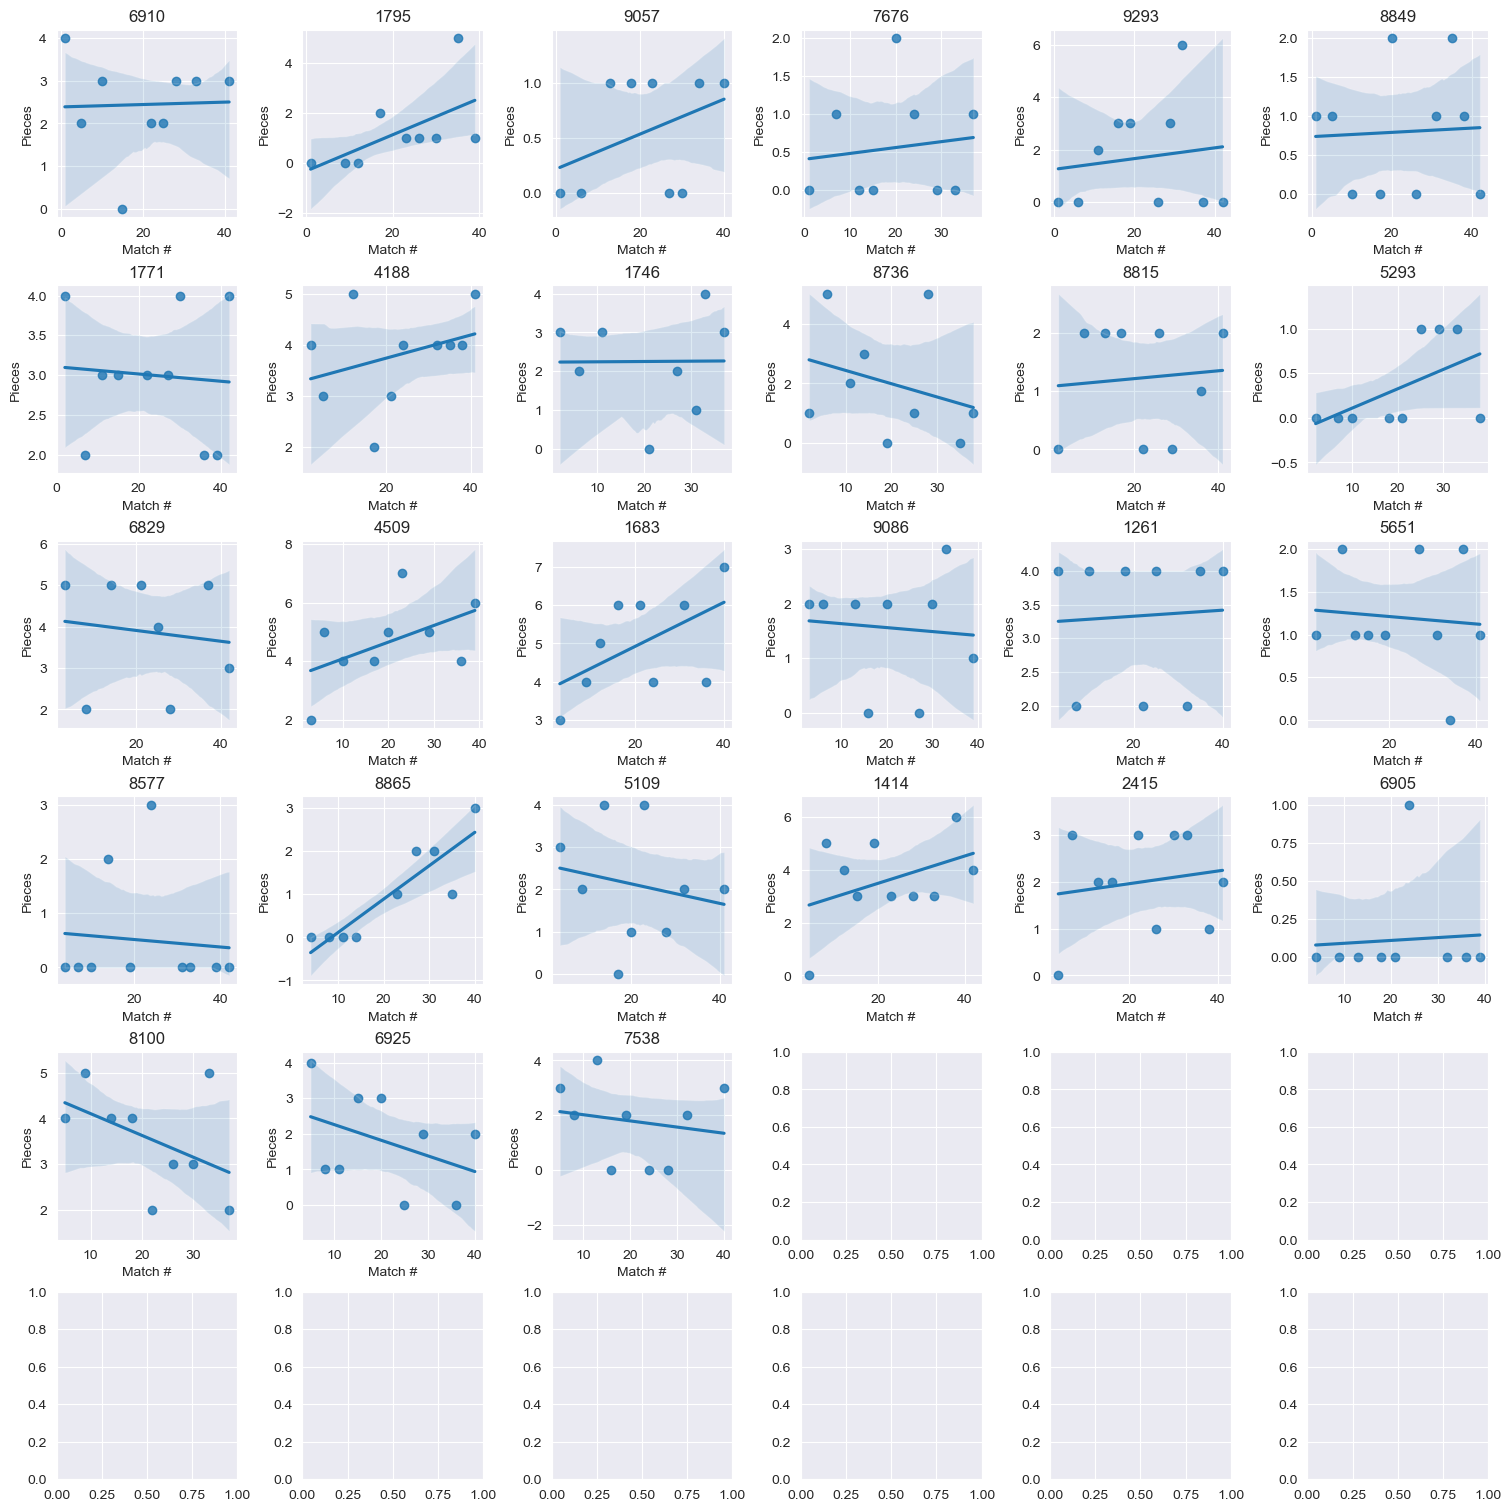

In [776]:
def performance_regression(df: pd.DataFrame, metric: Callable[])
    present_teams = get_teams_present(input_df)
    sq_size = math.ceil(math.sqrt(len(present_teams)))
    fig, axs = plt.subplots(nrows=sq_size, ncols=sq_size, figsize=(15, 15), constrained_layout=True)
    # fig.tight_layout()

    for i, team in enumerate(present_teams):
        scored_pieces = {}
        for match in get_played_matches(input_df, team):
            grid = get_grid_rows(organize_by_teams(input_df).get(team), mode=QuestionCategories.Teleop, matches=[match])
            calculated_grid = calculate_grid_statistics(grid, point_weighted=False)

            grid_np = calculated_grid.to_numpy()
            scored_pieces[match] = grid_np.sum()

        ax: plt.Axes = axs[i // sq_size, i % sq_size]
        ax.set_title(team)

        sns.regplot(x="Match #", y="Pieces", data=pd.DataFrame(data=scored_pieces.items(), columns=["Match #", "Pieces"]), ax=ax)